# Notebook 2: Building Our Pattern Detective
## The Mathematics Behind EOF Analysis

Welcome back! In Notebook 1, you discovered that complex data contains hidden patterns. Now we'll build the mathematical tools to automatically find these patterns. Think of this as learning to be a data detective with mathematical superpowers!

**What you'll learn:**
- How to find the "most important" directions in data
- What Singular Value Decomposition (SVD) actually does
- How SVD connects to finding patterns in spatiotemporal data
- Step-by-step implementation of EOF analysis
- How to interpret and validate your results

**Prerequisites:** 
- Completed Notebook 1
- Basic understanding of matrices and vectors
- Curiosity about how mathematics can reveal hidden truths!

---

## Part 1: The Intuition - Finding the Most Important Direction

Before diving into complex mathematics, let's build intuition about what we're trying to accomplish.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

# Set up nice plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

### The Fundamental Question: What Direction Captures the Most Variation?

Imagine you're looking at a cloud of data points. If you had to draw a single line through this cloud that captures the most information about the data, which direction would you choose?

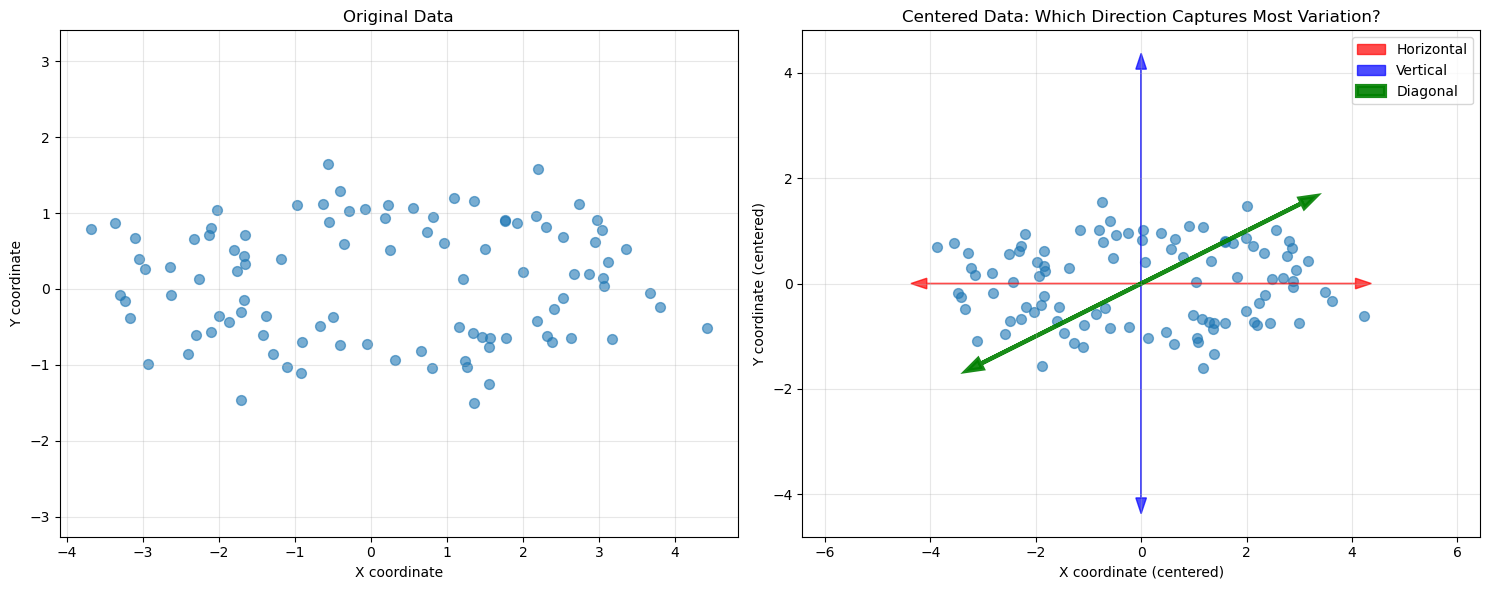

🤔 Think About It:
Which colored arrow seems to point in the direction where the data is most spread out?
This direction would capture the most 'variation' in the data.


In [3]:
def create_simple_2d_data(n_points=100, seed=42):
    """
    Create a simple 2D dataset where we can visualize the concept
    of "most important direction."
    """
    np.random.seed(seed)
    
    # Create data that's stretched more in one direction than another
    # This makes the "most important direction" obvious to see
    angle = np.pi/6  # 30 degrees
    stretch_x = 3.0
    stretch_y = 1.0
    
    # Start with circular data
    theta = np.random.uniform(0, 2*np.pi, n_points)
    r = np.random.normal(1.0, 0.3, n_points)
    x_orig = r * np.cos(theta)
    y_orig = r * np.sin(theta)
    
    # Stretch and rotate to create elongated pattern
    x = stretch_x * (x_orig * np.cos(angle) - y_orig * np.sin(angle))
    y = stretch_y * (x_orig * np.sin(angle) + y_orig * np.cos(angle))
    
    return np.column_stack([x, y])

def visualize_data_with_directions(data):
    """
    Show the data and help students think about which direction
    captures the most variation.
    """
    # Center the data (remove mean)
    data_centered = data - np.mean(data, axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original data
    axes[0].scatter(data[:, 0], data[:, 1], alpha=0.6, s=50)
    axes[0].set_title('Original Data')
    axes[0].set_xlabel('X coordinate')
    axes[0].set_ylabel('Y coordinate')
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    
    # Centered data with some potential directions
    axes[1].scatter(data_centered[:, 0], data_centered[:, 1], alpha=0.6, s=50)
    
    # Draw some possible directions
    max_extent = np.max(np.abs(data_centered)) * 1.2
    
    # Horizontal direction
    axes[1].arrow(0, 0, max_extent*0.8, 0, head_width=0.2, head_length=0.3, 
                 fc='red', ec='red', alpha=0.7, label='Horizontal')
    axes[1].arrow(0, 0, -max_extent*0.8, 0, head_width=0.2, head_length=0.3, 
                 fc='red', ec='red', alpha=0.7)
    
    # Vertical direction  
    axes[1].arrow(0, 0, 0, max_extent*0.8, head_width=0.2, head_length=0.3,
                 fc='blue', ec='blue', alpha=0.7, label='Vertical')
    axes[1].arrow(0, 0, 0, -max_extent*0.8, head_width=0.2, head_length=0.3,
                 fc='blue', ec='blue', alpha=0.7)
    
    # Main diagonal direction (this should be the best!)
    axes[1].arrow(0, 0, max_extent*0.6, max_extent*0.3, head_width=0.2, head_length=0.3,
                 fc='green', ec='green', alpha=0.9, linewidth=3, label='Diagonal')
    axes[1].arrow(0, 0, -max_extent*0.6, -max_extent*0.3, head_width=0.2, head_length=0.3,
                 fc='green', ec='green', alpha=0.9, linewidth=3)
    
    axes[1].set_title('Centered Data: Which Direction Captures Most Variation?')
    axes[1].set_xlabel('X coordinate (centered)')
    axes[1].set_ylabel('Y coordinate (centered)')
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("🤔 Think About It:")
    print("Which colored arrow seems to point in the direction where the data is most spread out?")
    print("This direction would capture the most 'variation' in the data.")
    
    return data_centered

# Create and visualize our simple example
sample_data = create_simple_2d_data()
centered_data = visualize_data_with_directions(sample_data)

### Measuring Variation in Different Directions

Let's quantify this intuition by actually measuring how much variation we capture in different directions.

In [4]:
def measure_variation_in_direction(data, direction):
    """
    Project data onto a direction and measure how spread out it is.
    
    This is the key insight: the "best" direction is the one that
    maximizes the variance of the projected data.
    """
    # Normalize the direction vector
    direction = direction / np.linalg.norm(direction)
    
    # Project each data point onto this direction
    # (This is like casting shadows of all points onto a line)
    projections = np.dot(data, direction)
    
    # Measure the variance of these projections
    variance = np.var(projections)
    
    return projections, variance

def compare_directions(data):
    """
    Compare how much variation different directions capture.
    """
    # Test several directions
    directions = {
        'Horizontal': np.array([1, 0]),
        'Vertical': np.array([0, 1]),
        'Diagonal (45°)': np.array([1, 1]),
        'Steep diagonal': np.array([1, 0.5]),
        'Gentle diagonal': np.array([1, 1.5])
    }
    
    results = {}
    
    print("📊 Variation Captured by Different Directions:")
    print("-" * 50)
    
    for name, direction in directions.items():
        projections, variance = measure_variation_in_direction(data, direction)
        results[name] = {'projections': projections, 'variance': variance}
        print(f"{name:18s}: {variance:.3f}")
    
    # Find the best direction we tested
    best_direction = max(results.keys(), key=lambda k: results[k]['variance'])
    print(f"\nBest direction tested: {best_direction}")
    print(f"Variance captured: {results[best_direction]['variance']:.3f}")
    
    return results

# Test different directions
direction_results = compare_directions(centered_data)

📊 Variation Captured by Different Directions:
--------------------------------------------------
Horizontal        : 4.345
Vertical          : 0.578
Diagonal (45°)    : 2.485
Steep diagonal    : 3.610
Gentle diagonal   : 1.758

Best direction tested: Horizontal
Variance captured: 4.345


### The Mathematical Goal: Finding the Optimal Direction

The direction that captures the most variation isn't always obvious, especially in higher dimensions. We need a systematic mathematical approach.

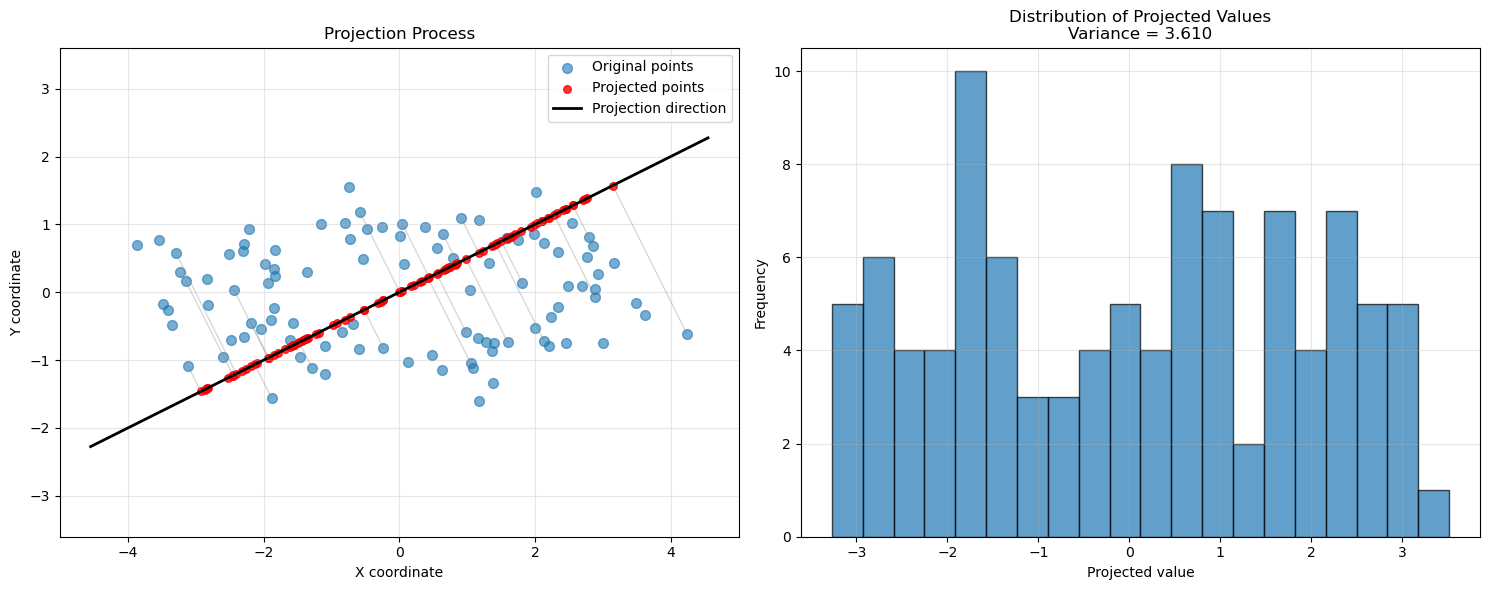

💡 Key Insight:
We projected 2D data onto a 1D line. The variance of the projected
values tells us how much information this direction captures.


In [5]:
def visualize_projection_concept(data, direction):
    """
    Show what it means to "project" data onto a direction.
    This visualization helps students understand the core concept.
    """
    # Normalize direction
    direction = direction / np.linalg.norm(direction)
    
    # Calculate projections
    projections = np.dot(data, direction)
    
    # Calculate projected points (back in 2D space)
    projected_points = projections[:, np.newaxis] * direction[np.newaxis, :]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Show the projection process
    axes[0].scatter(data[:, 0], data[:, 1], alpha=0.6, s=50, label='Original points')
    axes[0].scatter(projected_points[:, 0], projected_points[:, 1], 
                   alpha=0.8, s=30, color='red', label='Projected points')
    
    # Draw the direction line
    max_extent = np.max(np.abs(data)) * 1.2
    line_end = direction * max_extent
    axes[0].plot([-line_end[0], line_end[0]], [-line_end[1], line_end[1]], 
                'k-', linewidth=2, label='Projection direction')
    
    # Draw projection lines
    for i in range(0, len(data), 5):  # Only show every 5th line to avoid clutter
        axes[0].plot([data[i, 0], projected_points[i, 0]], 
                    [data[i, 1], projected_points[i, 1]], 
                    'gray', alpha=0.3, linewidth=1)
    
    axes[0].set_title('Projection Process')
    axes[0].set_xlabel('X coordinate')
    axes[0].set_ylabel('Y coordinate')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    
    # Show the 1D projected data
    axes[1].hist(projections, bins=20, alpha=0.7, edgecolor='black')
    axes[1].set_title(f'Distribution of Projected Values\nVariance = {np.var(projections):.3f}')
    axes[1].set_xlabel('Projected value')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"💡 Key Insight:")
    print(f"We projected 2D data onto a 1D line. The variance of the projected")
    print(f"values tells us how much information this direction captures.")

# Demonstrate projection with the diagonal direction
diagonal_dir = np.array([1, 0.5])
visualize_projection_concept(centered_data, diagonal_dir)

---

## Part 2: Enter the Mathematics - Principal Component Analysis

Now that we understand the goal, let's learn the mathematical technique that finds the optimal direction automatically.

### The Covariance Matrix: Understanding Data Relationships

The first step is understanding how different dimensions of our data relate to each other.

🔍 Understanding the Covariance Matrix:
Data shape: (100, 2) (rows=points, columns=features)
Covariance matrix shape: (2, 2)

Covariance matrix:
[[4.38917082 0.02350502]
 [0.02350502 0.58351543]]

What each element means:
  [0,0] = 4.389 : Variance in X direction
  [1,1] = 0.584 : Variance in Y direction
  [0,1] = 0.024 : Covariance between X and Y
  [1,0] = 0.024 : Same as [0,1] (symmetric)

✅ Positive covariance: When X increases, Y tends to increase


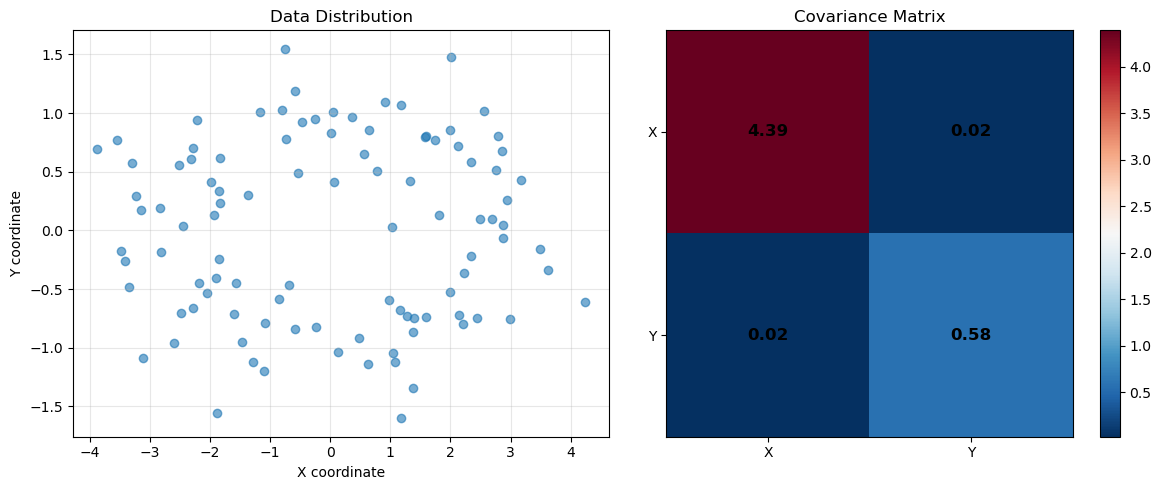

In [6]:
def explain_covariance_matrix(data):
    """
    Help students understand what a covariance matrix tells us
    about relationships in data.
    """
    # Calculate covariance matrix
    cov_matrix = np.cov(data.T)  # .T transposes so features are rows
    
    print("🔍 Understanding the Covariance Matrix:")
    print(f"Data shape: {data.shape} (rows=points, columns=features)")
    print(f"Covariance matrix shape: {cov_matrix.shape}")
    print()
    print("Covariance matrix:")
    print(cov_matrix)
    print()
    
    # Explain each element
    print("What each element means:")
    print(f"  [0,0] = {cov_matrix[0,0]:.3f} : Variance in X direction")
    print(f"  [1,1] = {cov_matrix[1,1]:.3f} : Variance in Y direction") 
    print(f"  [0,1] = {cov_matrix[0,1]:.3f} : Covariance between X and Y")
    print(f"  [1,0] = {cov_matrix[1,0]:.3f} : Same as [0,1] (symmetric)")
    print()
    
    if cov_matrix[0,1] > 0:
        print("✅ Positive covariance: When X increases, Y tends to increase")
    elif cov_matrix[0,1] < 0:
        print("✅ Negative covariance: When X increases, Y tends to decrease")
    else:
        print("✅ Zero covariance: X and Y are uncorrelated")
    
    # Visualize the covariance matrix
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Data scatter plot
    axes[0].scatter(data[:, 0], data[:, 1], alpha=0.6)
    axes[0].set_title('Data Distribution')
    axes[0].set_xlabel('X coordinate')
    axes[0].set_ylabel('Y coordinate')
    axes[0].grid(True, alpha=0.3)
    
    # Covariance matrix heatmap
    im = axes[1].imshow(cov_matrix, cmap='RdBu_r', aspect='equal')
    axes[1].set_title('Covariance Matrix')
    axes[1].set_xticks([0, 1])
    axes[1].set_yticks([0, 1])
    axes[1].set_xticklabels(['X', 'Y'])
    axes[1].set_yticklabels(['X', 'Y'])
    
    # Add values to the heatmap
    for i in range(2):
        for j in range(2):
            axes[1].text(j, i, f'{cov_matrix[i,j]:.2f}', 
                        ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=axes[1])
    plt.tight_layout()
    plt.show()
    
    return cov_matrix

# Analyze our sample data
cov_matrix = explain_covariance_matrix(centered_data)

### Eigenvalues and Eigenvectors: The Magic Behind Principal Components

The optimal directions we're looking for are the eigenvectors of the covariance matrix!

🎯 Eigenanalysis Results:
Eigenvalue 1: 4.389
Eigenvector 1: [1.000, 0.006]
Eigenvalue 2: 0.583
Eigenvector 2: [-0.006, 1.000]

💡 What This Means:
- The first eigenvector points in the direction of maximum variance
- The eigenvalue tells us how much variance that direction captures
- Principal Component 1 captures 4.4 units of variance
- Principal Component 2 captures 0.6 units of variance
- Verified: PC1 captures variance = 4.345
- Verified: PC2 captures variance = 0.578


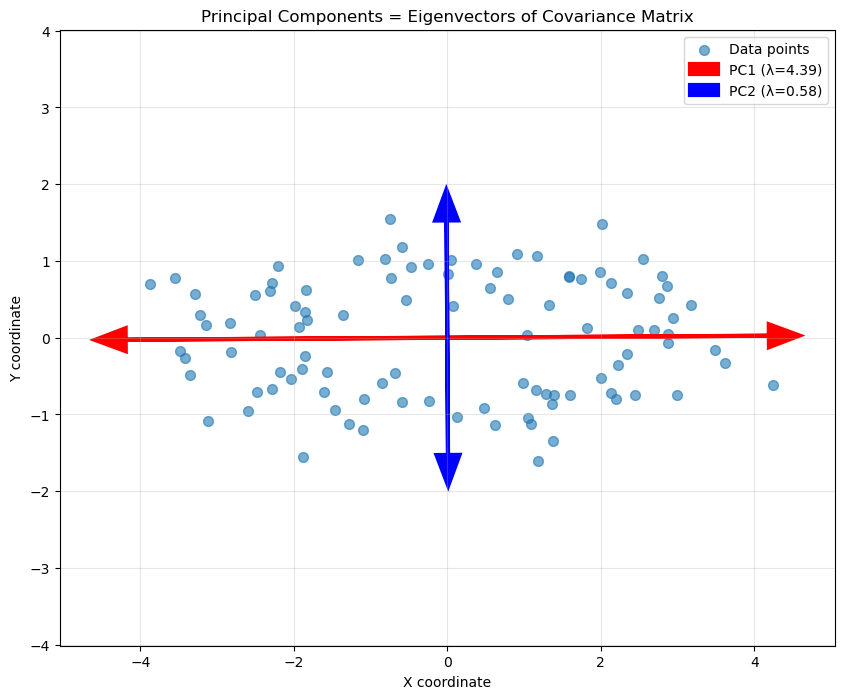

In [7]:
def explain_eigenanalysis(cov_matrix, data):
    """
    Show how eigenanalysis finds the principal directions automatically.
    """
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort by eigenvalue (largest first)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    print("🎯 Eigenanalysis Results:")
    print(f"Eigenvalue 1: {eigenvalues[0]:.3f}")
    print(f"Eigenvector 1: [{eigenvectors[0,0]:.3f}, {eigenvectors[1,0]:.3f}]")
    print(f"Eigenvalue 2: {eigenvalues[1]:.3f}")  
    print(f"Eigenvector 2: [{eigenvectors[0,1]:.3f}, {eigenvectors[1,1]:.3f}]")
    print()
    
    print("💡 What This Means:")
    print(f"- The first eigenvector points in the direction of maximum variance")
    print(f"- The eigenvalue tells us how much variance that direction captures")
    print(f"- Principal Component 1 captures {eigenvalues[0]:.1f} units of variance")
    print(f"- Principal Component 2 captures {eigenvalues[1]:.1f} units of variance")
    
    # Verify these are the optimal directions
    for i in range(2):
        projections, variance = measure_variation_in_direction(data, eigenvectors[:, i])
        print(f"- Verified: PC{i+1} captures variance = {variance:.3f}")
    
    # Visualize the principal components
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot data
    ax.scatter(data[:, 0], data[:, 1], alpha=0.6, s=50, label='Data points')
    
    # Plot principal components as arrows
    max_extent = np.max(np.abs(data)) * 1.2
    
    # First principal component (red arrow)
    pc1_scaled = eigenvectors[:, 0] * np.sqrt(eigenvalues[0]) * 2
    ax.arrow(0, 0, pc1_scaled[0], pc1_scaled[1], 
             head_width=0.3, head_length=0.4, fc='red', ec='red', 
             linewidth=3, label=f'PC1 (λ={eigenvalues[0]:.2f})')
    ax.arrow(0, 0, -pc1_scaled[0], -pc1_scaled[1], 
             head_width=0.3, head_length=0.4, fc='red', ec='red', linewidth=3)
    
    # Second principal component (blue arrow)  
    pc2_scaled = eigenvectors[:, 1] * np.sqrt(eigenvalues[1]) * 2
    ax.arrow(0, 0, pc2_scaled[0], pc2_scaled[1],
             head_width=0.3, head_length=0.4, fc='blue', ec='blue',
             linewidth=3, label=f'PC2 (λ={eigenvalues[1]:.2f})')
    ax.arrow(0, 0, -pc2_scaled[0], -pc2_scaled[1],
             head_width=0.3, head_length=0.4, fc='blue', ec='blue', linewidth=3)
    
    ax.set_title('Principal Components = Eigenvectors of Covariance Matrix')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    plt.show()
    
    return eigenvalues, eigenvectors

# Find the principal components
eigenvalues, eigenvectors = explain_eigenanalysis(cov_matrix, centered_data)

### Principal Component Transformation

Now let's see what happens when we transform our data into the principal component coordinate system.

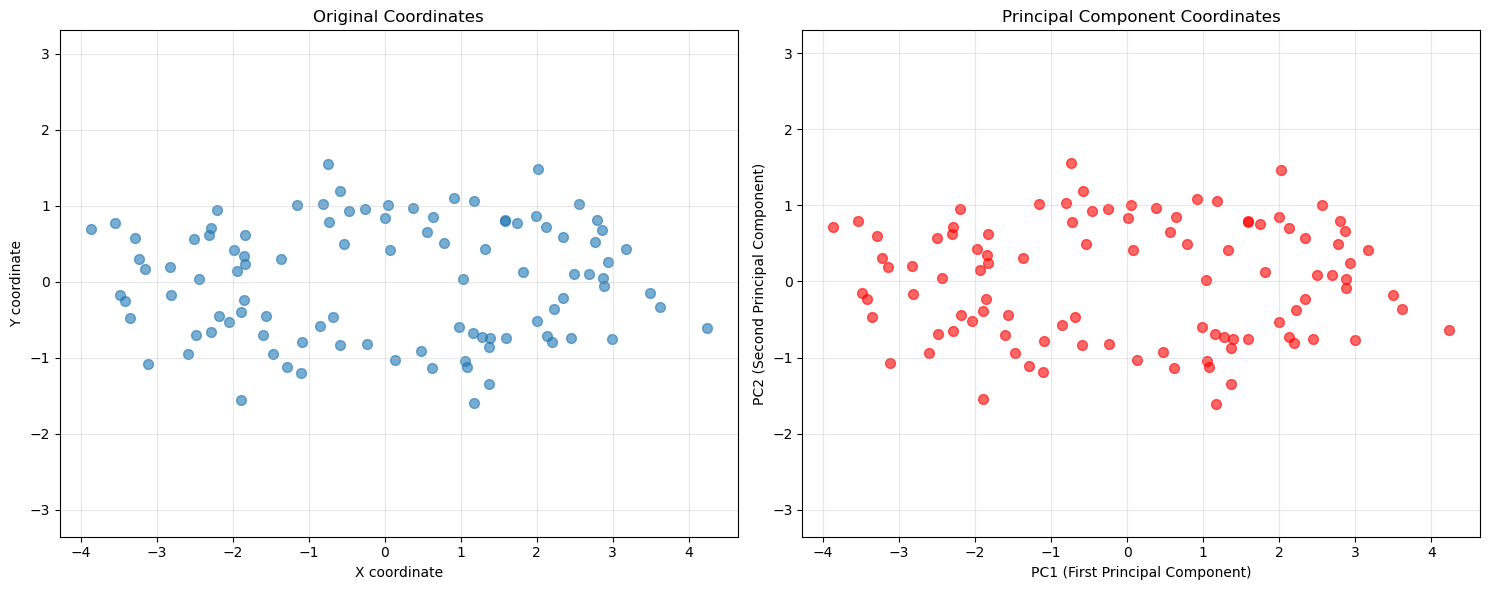

🔄 Coordinate Transformation Results:
Original data variance in X: 4.345
Original data variance in Y: 0.578
PC data variance in PC1: 4.345
PC data variance in PC2: 0.578

✨ Magic: In PC coordinates, PC1 and PC2 are uncorrelated!
Covariance between PC1 and PC2: -0.000000


In [10]:
def demonstrate_pc_transformation(data, eigenvectors):
    """
    Show how data looks in the principal component coordinate system.
    """
    # Transform data to PC coordinates
    pc_data = np.dot(data, eigenvectors)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original data
    axes[0].scatter(data[:, 0], data[:, 1], alpha=0.6, s=50)
    axes[0].set_title('Original Coordinates')
    axes[0].set_xlabel('X coordinate')
    axes[0].set_ylabel('Y coordinate')
    axes[0].grid(True, alpha=0.3)
    axes[0].axis('equal')
    
    # PC-transformed data
    axes[1].scatter(pc_data[:, 0], pc_data[:, 1], alpha=0.6, s=50, color='red')
    axes[1].set_title('Principal Component Coordinates')
    axes[1].set_xlabel('PC1 (First Principal Component)')
    axes[1].set_ylabel('PC2 (Second Principal Component)')
    axes[1].grid(True, alpha=0.3)
    axes[1].axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    print("🔄 Coordinate Transformation Results:")
    print(f"Original data variance in X: {np.var(data[:, 0]):.3f}")
    print(f"Original data variance in Y: {np.var(data[:, 1]):.3f}")
    print(f"PC data variance in PC1: {np.var(pc_data[:, 0]):.3f}")
    print(f"PC data variance in PC2: {np.var(pc_data[:, 1]):.3f}")
    print()
    print("✨ Magic: In PC coordinates, PC1 and PC2 are uncorrelated!")
    print(f"Covariance between PC1 and PC2: {np.cov(pc_data.T)[0,1]:.6f}")
    
    return pc_data

# Transform to principal component coordinates
pc_transformed = demonstrate_pc_transformation(centered_data, eigenvectors)

## Part 3: From 2D to Many Dimensions - Singular Value Decomposition

PCA works great for understanding the concept, but real spatiotemporal data has many more dimensions. This is where Singular Value Decomposition (SVD) becomes essential.

### Understanding the Data Matrix Structure

Let's reconnect with spatiotemporal data and see how it fits into the mathematical framework.

📋 Spatiotemporal Data Structure:
Data shape: (50, 30) (time × space)
  - 50 time steps
  - 30 spatial locations
  - 1500 total data points

🎯 Our Goal: Find the main patterns (modes) in this data


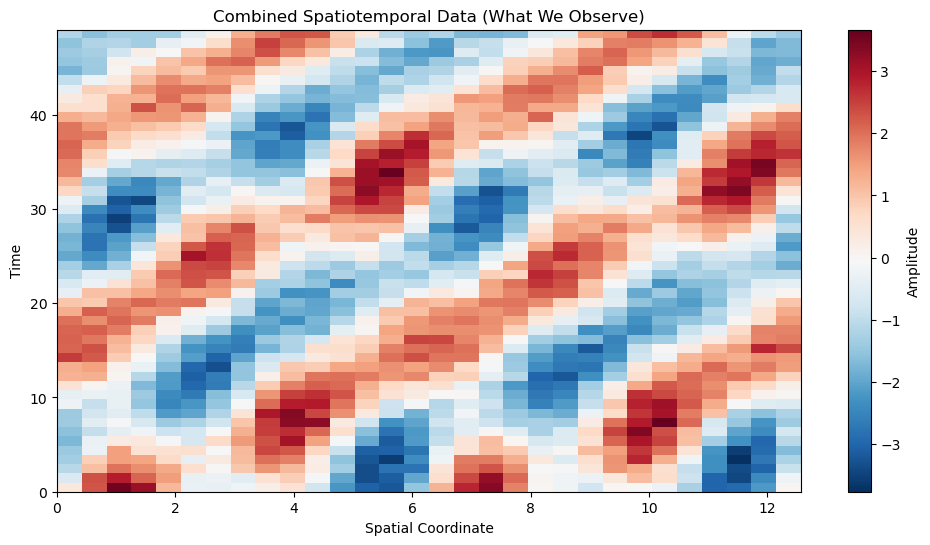

In [11]:
def setup_spatiotemporal_example():
    """
    Create a spatiotemporal dataset and show how it becomes a matrix
    suitable for SVD analysis.
    """
    # Create synthetic spatiotemporal data (similar to Notebook 1)
    np.random.seed(42)
    n_times = 50
    n_locations = 30
    
    # Create two patterns
    x = np.linspace(0, 4*np.pi, n_locations)
    t = np.arange(n_times)
    
    # Pattern 1: Traveling wave
    pattern1 = np.zeros((n_times, n_locations))
    for i, time in enumerate(t):
        pattern1[i, :] = 2.0 * np.sin(x - 0.3 * time)
    
    # Pattern 2: Standing wave with temporal modulation
    pattern2 = np.zeros((n_times, n_locations))
    spatial_mode = np.sin(2*x)
    temporal_mode = np.cos(0.1 * t)
    for i, amp in enumerate(temporal_mode):
        pattern2[i, :] = 1.5 * amp * spatial_mode
    
    # Combine patterns + noise
    noise = 0.3 * np.random.randn(n_times, n_locations)
    combined_data = pattern1 + pattern2 + noise
    
    # Remove temporal mean (create anomalies)
    data_anomalies = combined_data - np.mean(combined_data, axis=0, keepdims=True)
    
    print("📋 Spatiotemporal Data Structure:")
    print(f"Data shape: {data_anomalies.shape} (time × space)")
    print(f"  - {n_times} time steps")
    print(f"  - {n_locations} spatial locations") 
    print(f"  - {n_times * n_locations} total data points")
    print()
    print("🎯 Our Goal: Find the main patterns (modes) in this data")
    
    return data_anomalies, pattern1, pattern2, x, t

# Create our spatiotemporal example
data_matrix, true_pattern1, true_pattern2, x_coords, t_coords = setup_spatiotemporal_example()

# Visualize the combined data
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(data_matrix, aspect='auto', origin='lower', cmap='RdBu_r',
               extent=[x_coords[0], x_coords[-1], t_coords[0], t_coords[-1]])
ax.set_title('Combined Spatiotemporal Data (What We Observe)')
ax.set_xlabel('Spatial Coordinate')
ax.set_ylabel('Time')
plt.colorbar(im, label='Amplitude')
plt.show()

### SVD: The Mathematical Engine

SVD decomposes our data matrix into three components that reveal the hidden patterns.

🔍 SVD Decomposition Results:
Original data shape: (50, 30)
U shape: (50, 30) - Temporal patterns (time × modes)
s shape: (30,) - Singular values (strength of each mode)
Vt shape: (30, 30) - Spatial patterns (modes × space)

📊 Mode Importance (Singular Values):
  Mode 1: σ = 40.733, explains 42.9% of variance
  Mode 2: σ = 37.839, explains 37.0% of variance
  Mode 3: σ = 25.809, explains 17.2% of variance
  Mode 4: σ = 3.284, explains 0.3% of variance
  Mode 5: σ = 3.155, explains 0.3% of variance

First 3 modes explain 97.2% of total variance


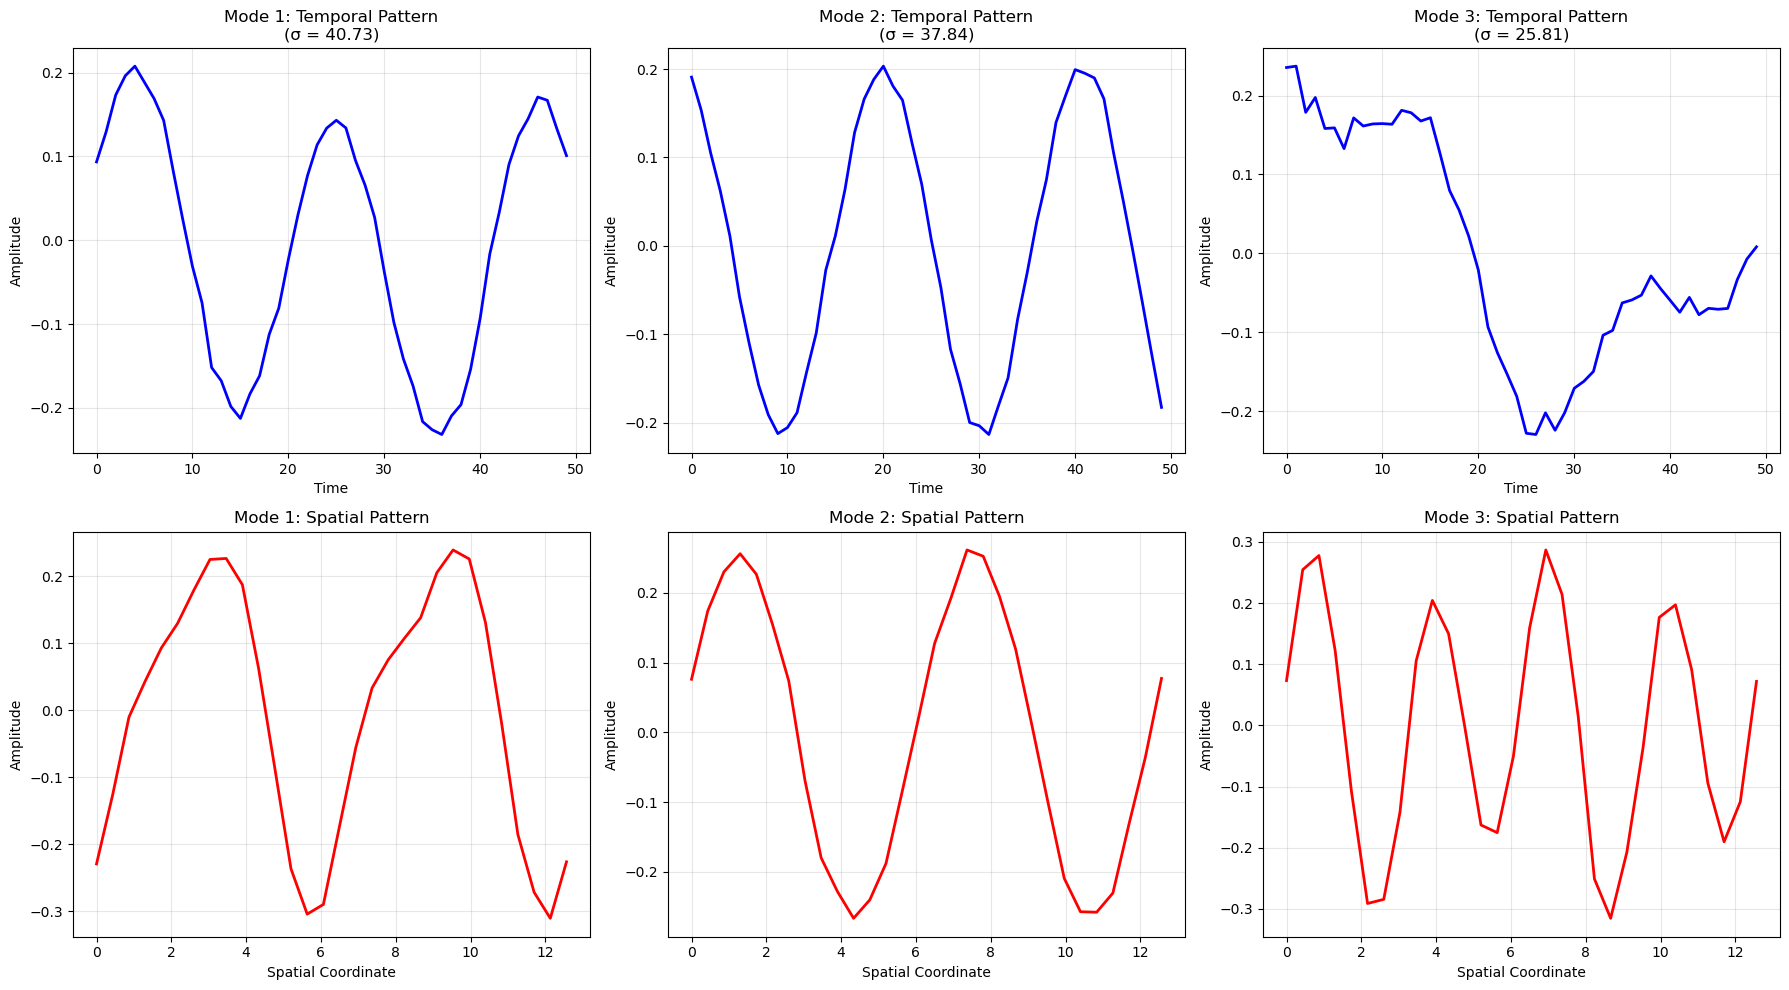


💡 Interpretation:
Each mode represents a distinct spatiotemporal pattern:
- Temporal pattern: How this mode changes over time
- Spatial pattern: Where this mode is active in space
- Singular value: How important this mode is overall


In [12]:
def explain_svd_decomposition(data_matrix):
    """
    Perform SVD and explain what each component represents in the context
    of spatiotemporal pattern analysis.
    """
    # Perform SVD
    U, s, Vt = np.linalg.svd(data_matrix, full_matrices=False)
    
    print("🔍 SVD Decomposition Results:")
    print(f"Original data shape: {data_matrix.shape}")
    print(f"U shape: {U.shape} - Temporal patterns (time × modes)")
    print(f"s shape: {s.shape} - Singular values (strength of each mode)")
    print(f"Vt shape: {Vt.shape} - Spatial patterns (modes × space)")
    print()
    
    # Calculate explained variance ratios
    explained_variance = s**2
    variance_ratios = explained_variance / np.sum(explained_variance)
    
    print("📊 Mode Importance (Singular Values):")
    for i in range(min(5, len(s))):
        print(f"  Mode {i+1}: σ = {s[i]:.3f}, explains {variance_ratios[i]*100:.1f}% of variance")
    
    print(f"\nFirst 3 modes explain {np.sum(variance_ratios[:3])*100:.1f}% of total variance")
    
    # Visualize the decomposition
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Show first 3 modes
    for mode in range(3):
        # Temporal pattern (U column)
        axes[0, mode].plot(t_coords, U[:, mode], 'b-', linewidth=2)
        axes[0, mode].set_title(f'Mode {mode+1}: Temporal Pattern\n(σ = {s[mode]:.2f})')
        axes[0, mode].set_xlabel('Time')
        axes[0, mode].set_ylabel('Amplitude')
        axes[0, mode].grid(True, alpha=0.3)
        
        # Spatial pattern (Vt row)
        axes[1, mode].plot(x_coords, Vt[mode, :], 'r-', linewidth=2)
        axes[1, mode].set_title(f'Mode {mode+1}: Spatial Pattern')
        axes[1, mode].set_xlabel('Spatial Coordinate')
        axes[1, mode].set_ylabel('Amplitude')
        axes[1, mode].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretation:")
    print("Each mode represents a distinct spatiotemporal pattern:")
    print("- Temporal pattern: How this mode changes over time")
    print("- Spatial pattern: Where this mode is active in space")
    print("- Singular value: How important this mode is overall")
    
    return U, s, Vt, variance_ratios

# Perform and explain SVD
U, s, Vt, var_ratios = explain_svd_decomposition(data_matrix)

### Connecting SVD to EOF Analysis

Now let's make the explicit connection between SVD and the EOF analysis terminology used in science.


🔄 Translation: SVD ↔ EOF Analysis
SVD Term                → EOF Term
--------------------------------------------------
Vt rows (spatial)       → Empirical Orthogonal Functions (EOFs)
U columns (temporal)    → Principal Components (PCs)
s (singular values)     → Square root of eigenvalues
s²/sum(s²)             → Explained variance ratios

📐 Standard EOF Analysis Results:
EOFs shape: (30, 30) (space × modes)
PCs shape: (50, 30) (time × modes)

✅ Verification of Key Properties:
EOFs are orthogonal (spatial patterns are independent):
  Max off-diagonal element: 9.36e-16

PCs are uncorrelated (temporal patterns are independent):
  Max off-diagonal correlation: 1.35e-15


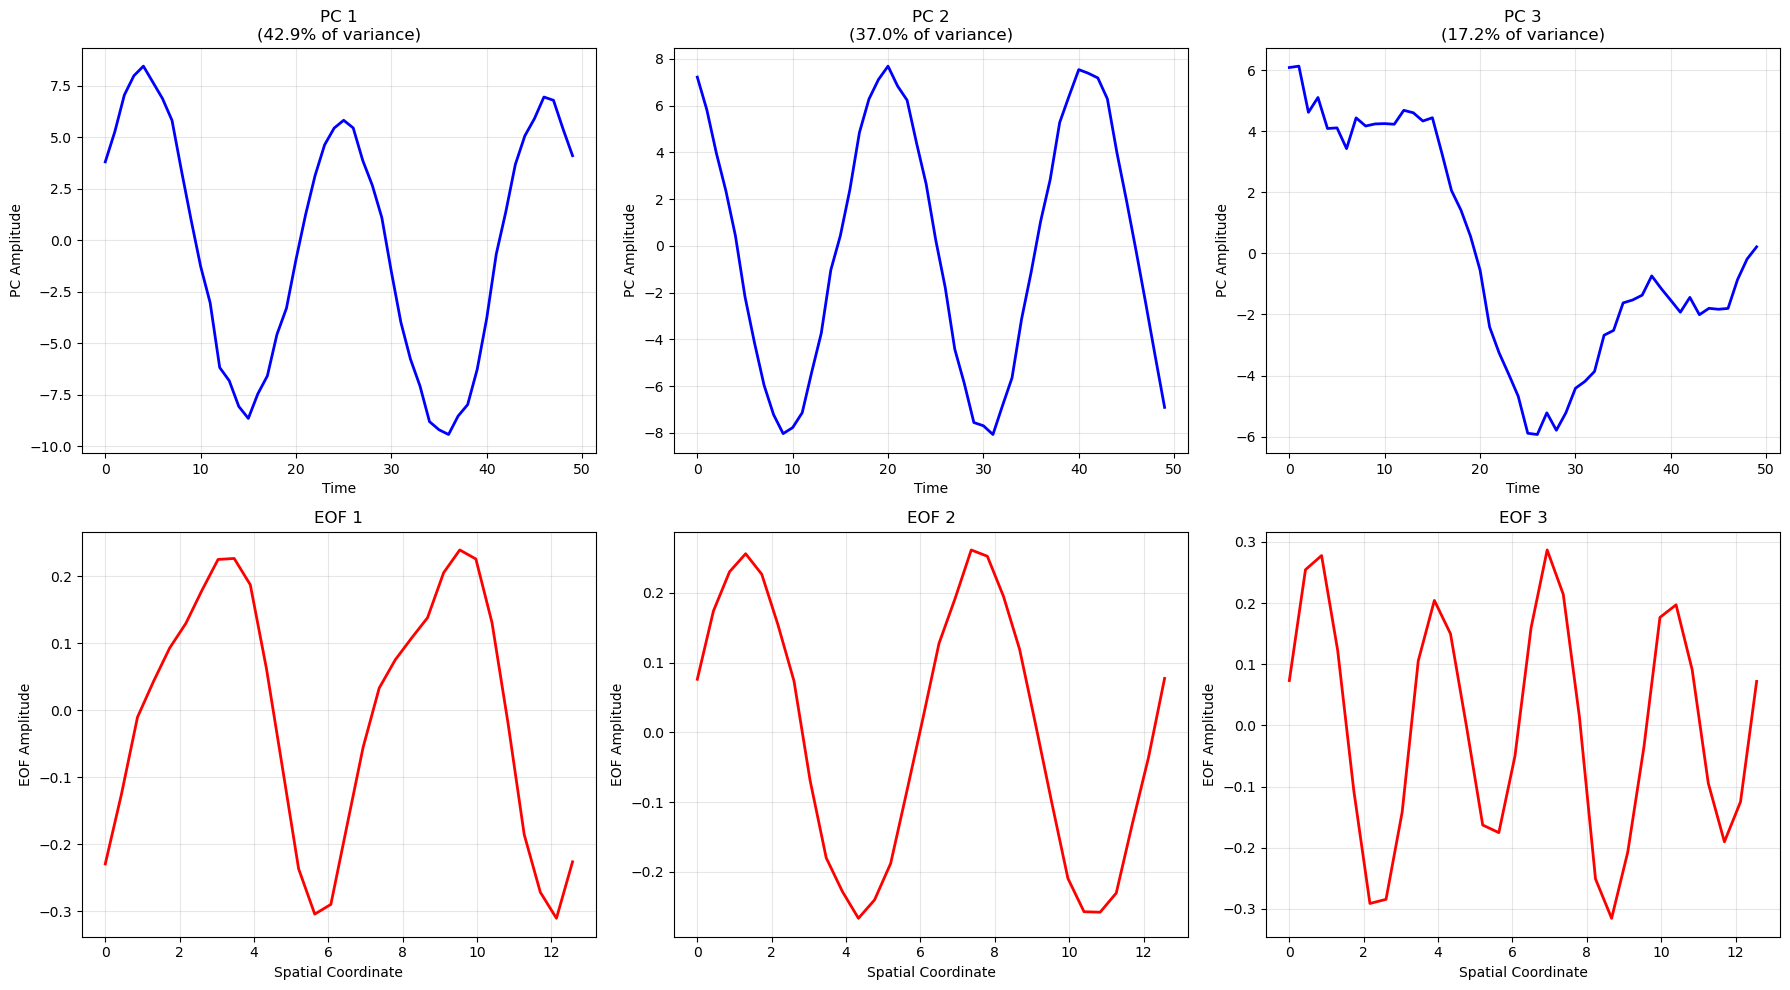

In [13]:
def connect_svd_to_eof(U, s, Vt, var_ratios):
    """
    Translate SVD results into EOF analysis terminology and show
    the equivalence between the mathematical and scientific perspectives.
    """
    print("🔄 Translation: SVD ↔ EOF Analysis")
    print("=" * 50)
    print("SVD Term                → EOF Term")
    print("-" * 50)
    print("Vt rows (spatial)       → Empirical Orthogonal Functions (EOFs)")
    print("U columns (temporal)    → Principal Components (PCs)")  
    print("s (singular values)     → Square root of eigenvalues")
    print("s²/sum(s²)             → Explained variance ratios")
    print()
    
    # Calculate EOFs and PCs in standard form
    EOFs = Vt.T  # Transpose so columns are EOFs
    PCs = U * s   # Scale by singular values
    
    print("📐 Standard EOF Analysis Results:")
    print(f"EOFs shape: {EOFs.shape} (space × modes)")
    print(f"PCs shape: {PCs.shape} (time × modes)")
    print()
    
    # Show orthogonality properties
    EOF_orthogonality = np.dot(EOFs.T, EOFs)
    PC_orthogonality = np.dot(PCs.T, PCs) / len(PCs)
    
    print("✅ Verification of Key Properties:")
    print("EOFs are orthogonal (spatial patterns are independent):")
    print(f"  Max off-diagonal element: {np.max(np.abs(EOF_orthogonality - np.diag(np.diag(EOF_orthogonality)))):.2e}")
    print()
    print("PCs are uncorrelated (temporal patterns are independent):")
    print(f"  Max off-diagonal correlation: {np.max(np.abs(np.corrcoef(PCs.T) - np.eye(len(s)))):.2e}")
    
    # Visualize EOFs and PCs in standard form
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for mode in range(3):
        # Principal Components (time series)
        axes[0, mode].plot(t_coords, PCs[:, mode], 'b-', linewidth=2)
        axes[0, mode].set_title(f'PC {mode+1}\n({var_ratios[mode]*100:.1f}% of variance)')
        axes[0, mode].set_xlabel('Time')
        axes[0, mode].set_ylabel('PC Amplitude')
        axes[0, mode].grid(True, alpha=0.3)
        
        # Empirical Orthogonal Functions (spatial patterns)
        axes[1, mode].plot(x_coords, EOFs[:, mode], 'r-', linewidth=2)
        axes[1, mode].set_title(f'EOF {mode+1}')
        axes[1, mode].set_xlabel('Spatial Coordinate')
        axes[1, mode].set_ylabel('EOF Amplitude')
        axes[1, mode].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return EOFs, PCs

# Make the connection explicit
EOFs, PCs = connect_svd_to_eof(U, s, Vt, var_ratios)

## Part 4: Reconstruction and Validation

A crucial aspect of EOF analysis is understanding how the modes combine to reconstruct the original data.

### Reconstructing Data from EOF Modes

🔧 Data Reconstruction from EOF Modes:
Using 1 mode(s): MSE = 1.4702, 42.9% variance explained
Using 2 mode(s): MSE = 0.5157, 80.0% variance explained
Using 3 mode(s): MSE = 0.0716, 97.2% variance explained
Using 5 mode(s): MSE = 0.0578, 97.8% variance explained


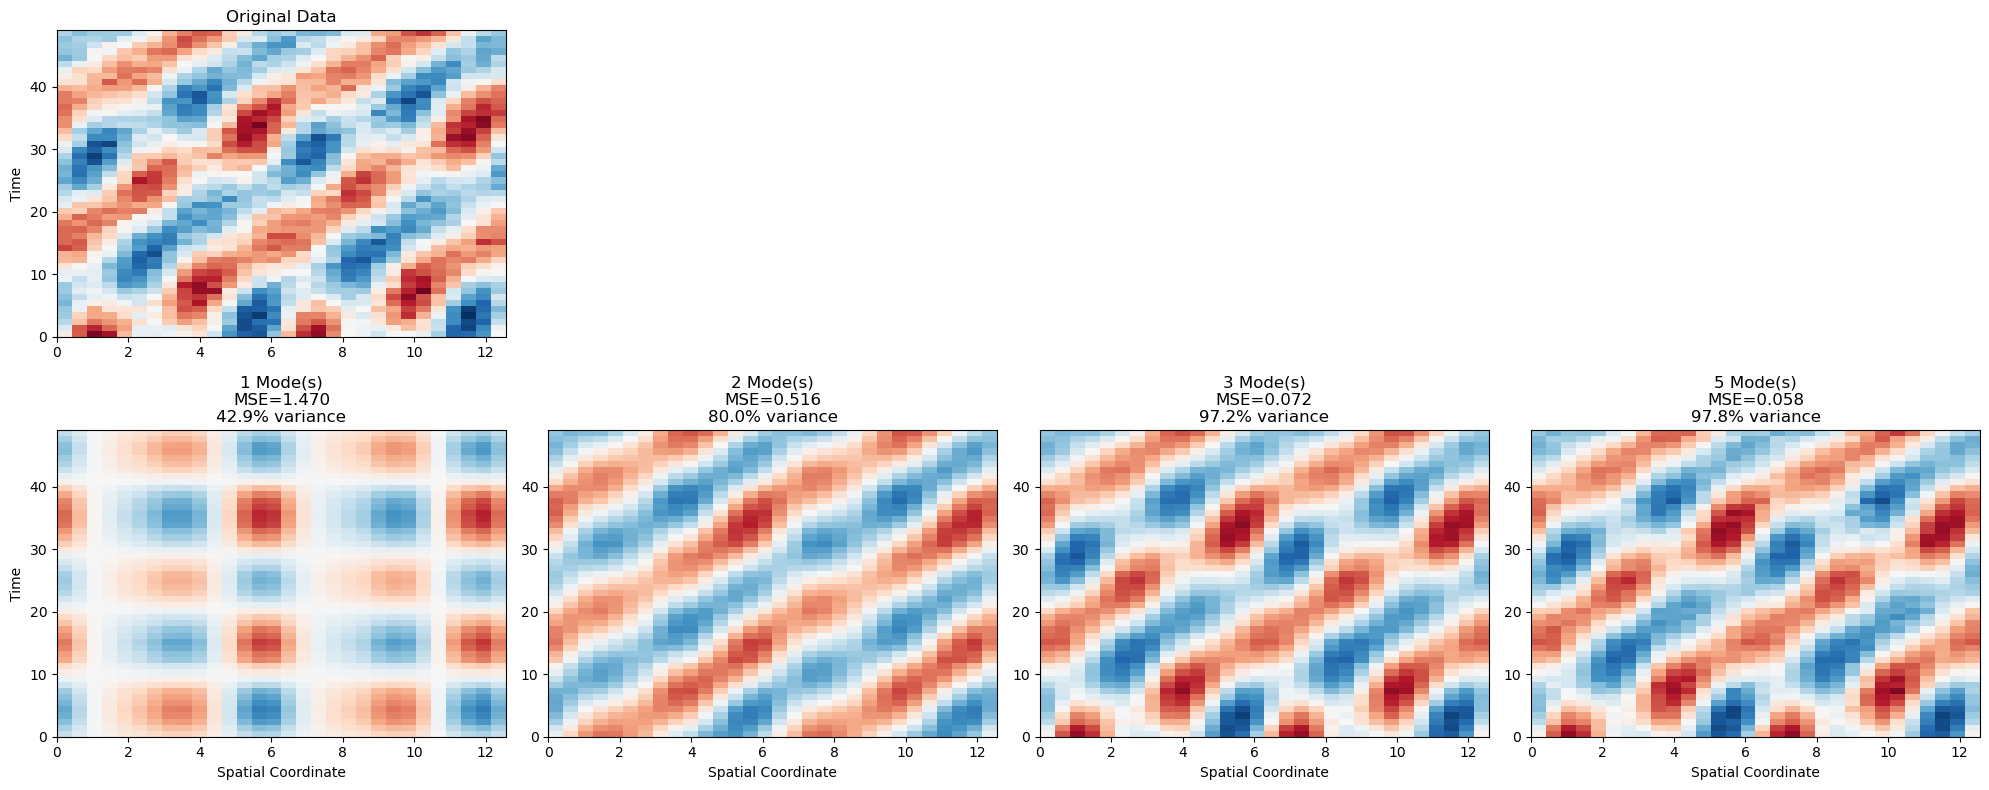


🎯 Key Insight:
As we include more modes, the reconstruction becomes more accurate.
The first few modes usually capture the most important patterns!


In [14]:
def demonstrate_reconstruction(data_matrix, U, s, Vt):
    """
    Show how individual modes combine to reconstruct the original data.
    This builds intuition about what each mode contributes.
    """
    print("🔧 Data Reconstruction from EOF Modes:")
    print("=" * 40)
    
    # Show reconstruction with different numbers of modes
    modes_to_test = [1, 2, 3, 5]
    
    fig, axes = plt.subplots(2, len(modes_to_test), figsize=(20, 8))
    
    for i, n_modes in enumerate(modes_to_test):
        # Reconstruct with first n_modes
        U_truncated = U[:, :n_modes]
        s_truncated = s[:n_modes]
        Vt_truncated = Vt[:n_modes, :]
        
        reconstructed = U_truncated @ np.diag(s_truncated) @ Vt_truncated
        
        # Calculate reconstruction error
        error = np.mean((data_matrix - reconstructed)**2)
        variance_explained = np.sum(s_truncated**2) / np.sum(s**2)
        
        # Plot original vs reconstructed
        vmax = np.max(np.abs(data_matrix))
        
        # Original data
        if i == 0:
            im1 = axes[0, i].imshow(data_matrix, aspect='auto', origin='lower', cmap='RdBu_r',
                                   extent=[x_coords[0], x_coords[-1], t_coords[0], t_coords[-1]],
                                   vmin=-vmax, vmax=vmax)
            axes[0, i].set_title('Original Data')
            axes[0, i].set_ylabel('Time')
        else:
            axes[0, i].axis('off')
        
        # Reconstructed data
        im2 = axes[1, i].imshow(reconstructed, aspect='auto', origin='lower', cmap='RdBu_r',
                               extent=[x_coords[0], x_coords[-1], t_coords[0], t_coords[-1]],
                               vmin=-vmax, vmax=vmax)
        axes[1, i].set_title(f'{n_modes} Mode(s)\nMSE={error:.3f}\n{variance_explained*100:.1f}% variance')
        axes[1, i].set_xlabel('Spatial Coordinate')
        if i == 0:
            axes[1, i].set_ylabel('Time')
        
        print(f"Using {n_modes} mode(s): MSE = {error:.4f}, {variance_explained*100:.1f}% variance explained")
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Key Insight:")
    print("As we include more modes, the reconstruction becomes more accurate.")
    print("The first few modes usually capture the most important patterns!")

# Demonstrate reconstruction
demonstrate_reconstruction(data_matrix, U, s, Vt)

### Comparing with True Patterns

Let's see how well our EOF analysis recovered the original patterns we put into the data.

🔍 Validation: Comparing Discovered Patterns with Truth


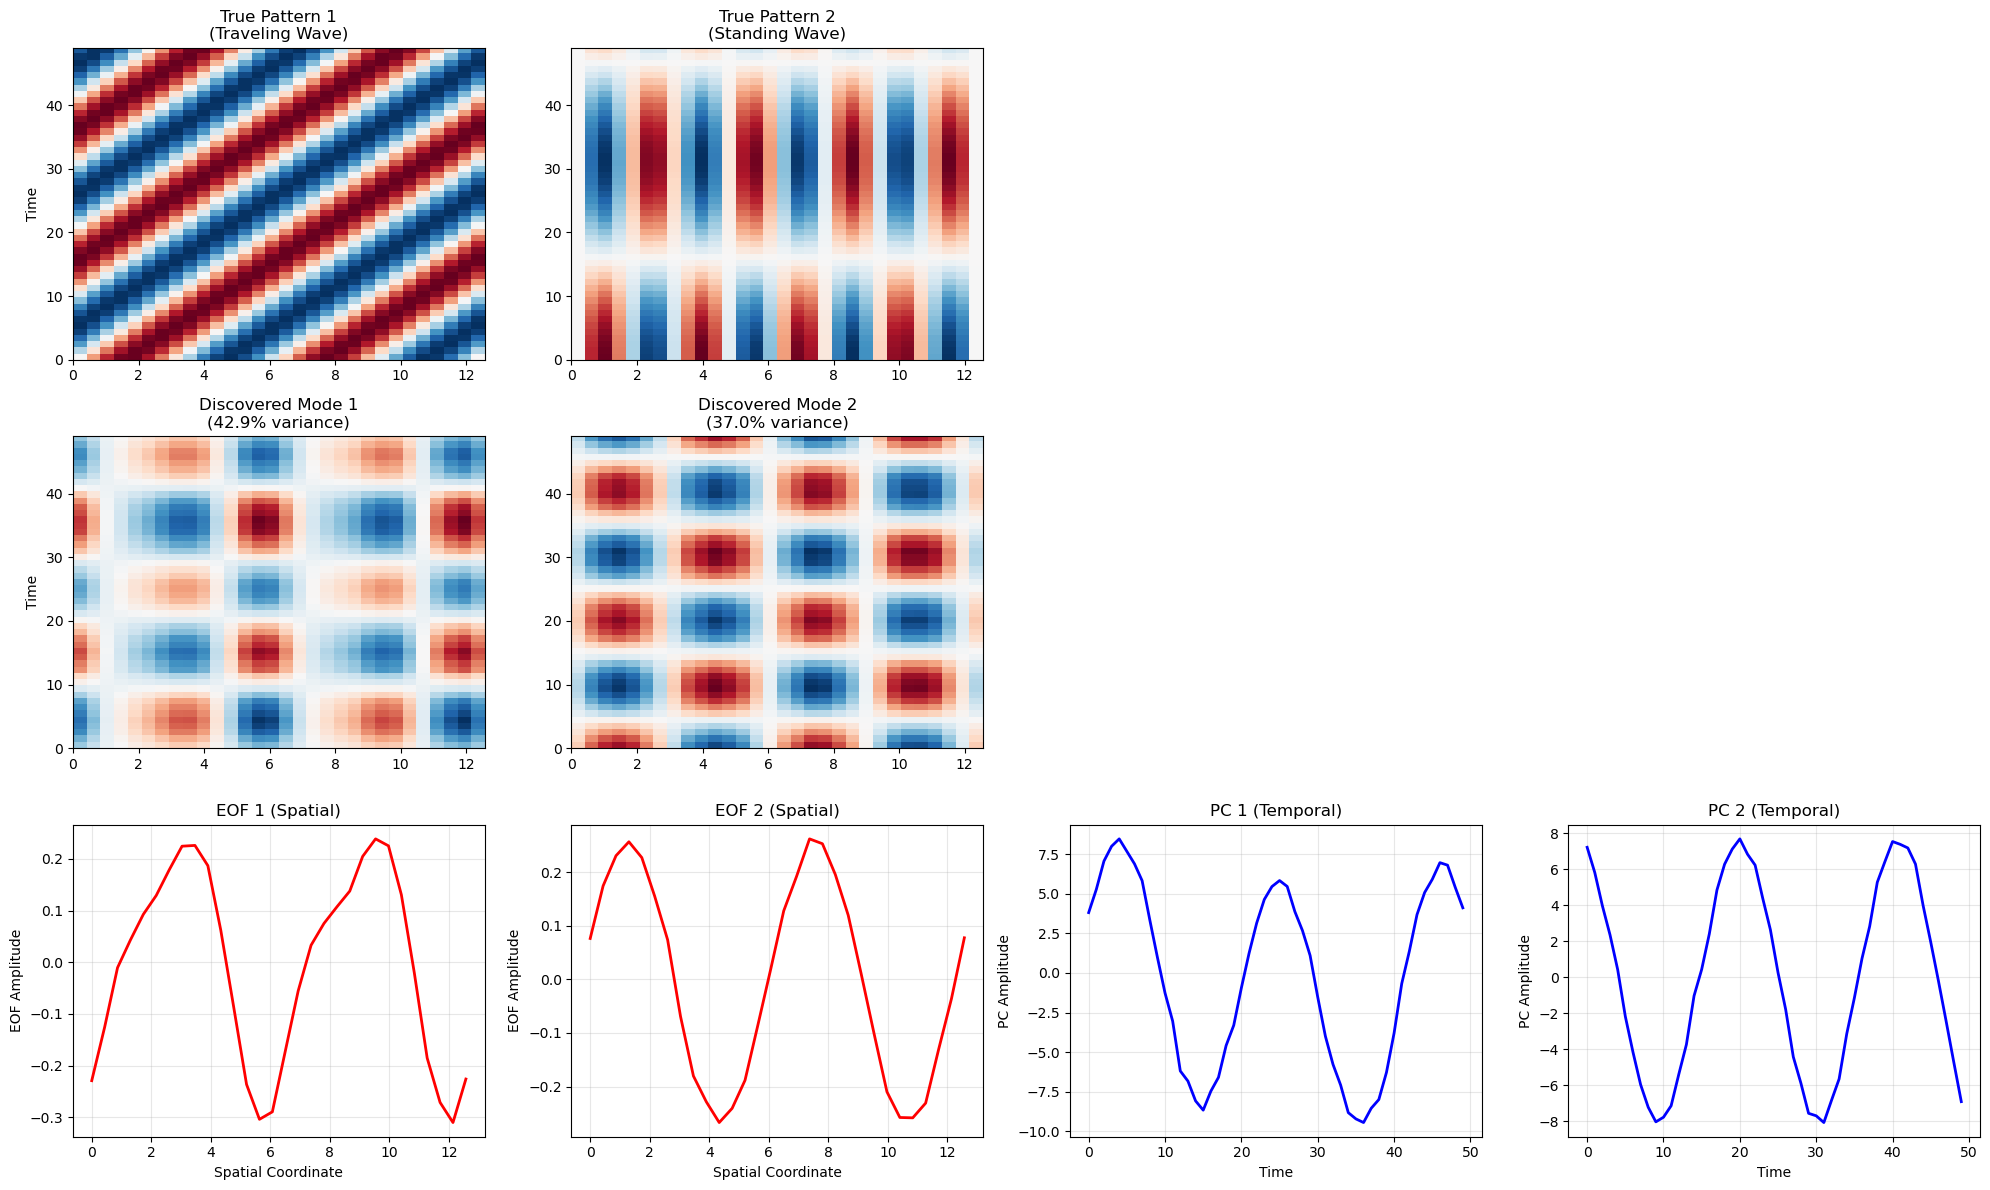

🎯 Analysis Results:
Mode 1 captures 42.9% of the variance
Mode 2 captures 37.0% of the variance
Together, they explain 80.0% of the total variance

✅ Success! The EOF analysis successfully identified the main
   spatiotemporal patterns hidden in the complex data!


In [16]:
def compare_with_truth(EOFs, PCs, true_pattern1, true_pattern2, var_ratios):
    """
    Compare the discovered EOFs with the true patterns we used to create the data.
    This validates our method and builds confidence.
    """
    print("🔍 Validation: Comparing Discovered Patterns with Truth")
    print("=" * 55)
    
    # We need to compare spatial and temporal patterns separately
    # since EOF analysis finds combined spatiotemporal modes
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    
    # True patterns
    axes[0, 0].imshow(true_pattern1, aspect='auto', origin='lower', cmap='RdBu_r',
                     extent=[x_coords[0], x_coords[-1], t_coords[0], t_coords[-1]])
    axes[0, 0].set_title('True Pattern 1\n(Traveling Wave)')
    axes[0, 0].set_ylabel('Time')
    
    axes[0, 1].imshow(true_pattern2, aspect='auto', origin='lower', cmap='RdBu_r',
                     extent=[x_coords[0], x_coords[-1], t_coords[0], t_coords[-1]])
    axes[0, 1].set_title('True Pattern 2\n(Standing Wave)')
    
    axes[0, 2].axis('off')
    axes[0, 3].axis('off')
    
    # Discovered EOF modes (reconstructed as spatiotemporal patterns)
    for mode in range(2):
        # Reconstruct this single mode
        mode_pattern = np.outer(PCs[:, mode], EOFs[:, mode])
        
        axes[1, mode].imshow(mode_pattern, aspect='auto', origin='lower', cmap='RdBu_r',
                           extent=[x_coords[0], x_coords[-1], t_coords[0], t_coords[-1]])
        axes[1, mode].set_title(f'Discovered Mode {mode+1}\n({var_ratios[mode]*100:.1f}% variance)')
        if mode == 0:
            axes[1, mode].set_ylabel('Time')
    
    axes[1, 2].axis('off')
    axes[1, 3].axis('off')
    
    # EOF spatial patterns and PC time series
    for mode in range(2):
        # Spatial pattern (EOF)
        axes[2, mode].plot(x_coords, EOFs[:, mode], 'r-', linewidth=2)
        axes[2, mode].set_title(f'EOF {mode+1} (Spatial)')
        axes[2, mode].set_xlabel('Spatial Coordinate')
        axes[2, mode].set_ylabel('EOF Amplitude')
        axes[2, mode].grid(True, alpha=0.3)
        
        # Temporal pattern (PC)
        axes[2, mode+2].plot(t_coords, PCs[:, mode], 'b-', linewidth=2)
        axes[2, mode+2].set_title(f'PC {mode+1} (Temporal)')
        axes[2, mode+2].set_xlabel('Time')
        axes[2, mode+2].set_ylabel('PC Amplitude')
        axes[2, mode+2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("🎯 Analysis Results:")
    print(f"Mode 1 captures {var_ratios[0]*100:.1f}% of the variance")
    print(f"Mode 2 captures {var_ratios[1]*100:.1f}% of the variance")
    print(f"Together, they explain {(var_ratios[0]+var_ratios[1])*100:.1f}% of the total variance")
    print()
    print("✅ Success! The EOF analysis successfully identified the main")
    print("   spatiotemporal patterns hidden in the complex data!")

# Compare with ground truth
compare_with_truth(EOFs, PCs, true_pattern1, true_pattern2, var_ratios)

## Part 5: Complete EOF Analysis Workflow

Let's now implement the complete EOF analysis workflow as a reusable function.

🧪 Testing Complete EOF Analysis on Our Example Data
🚀 Starting Complete EOF Analysis
1. Data Preprocessing...
   Data shape: (50, 30)
   Temporal mean removed at each location
2. SVD Decomposition...
   Found 30 total modes
   Analyzing first 5 modes
3. Mode Significance...
   Mode 1: 42.93% (cumulative: 42.93%)
   Mode 2: 37.05% (cumulative: 79.98%)
   Mode 3: 17.24% (cumulative: 97.22%)
   Mode 4: 0.28% (cumulative: 97.50%)
   Mode 5: 0.26% (cumulative: 97.76%)


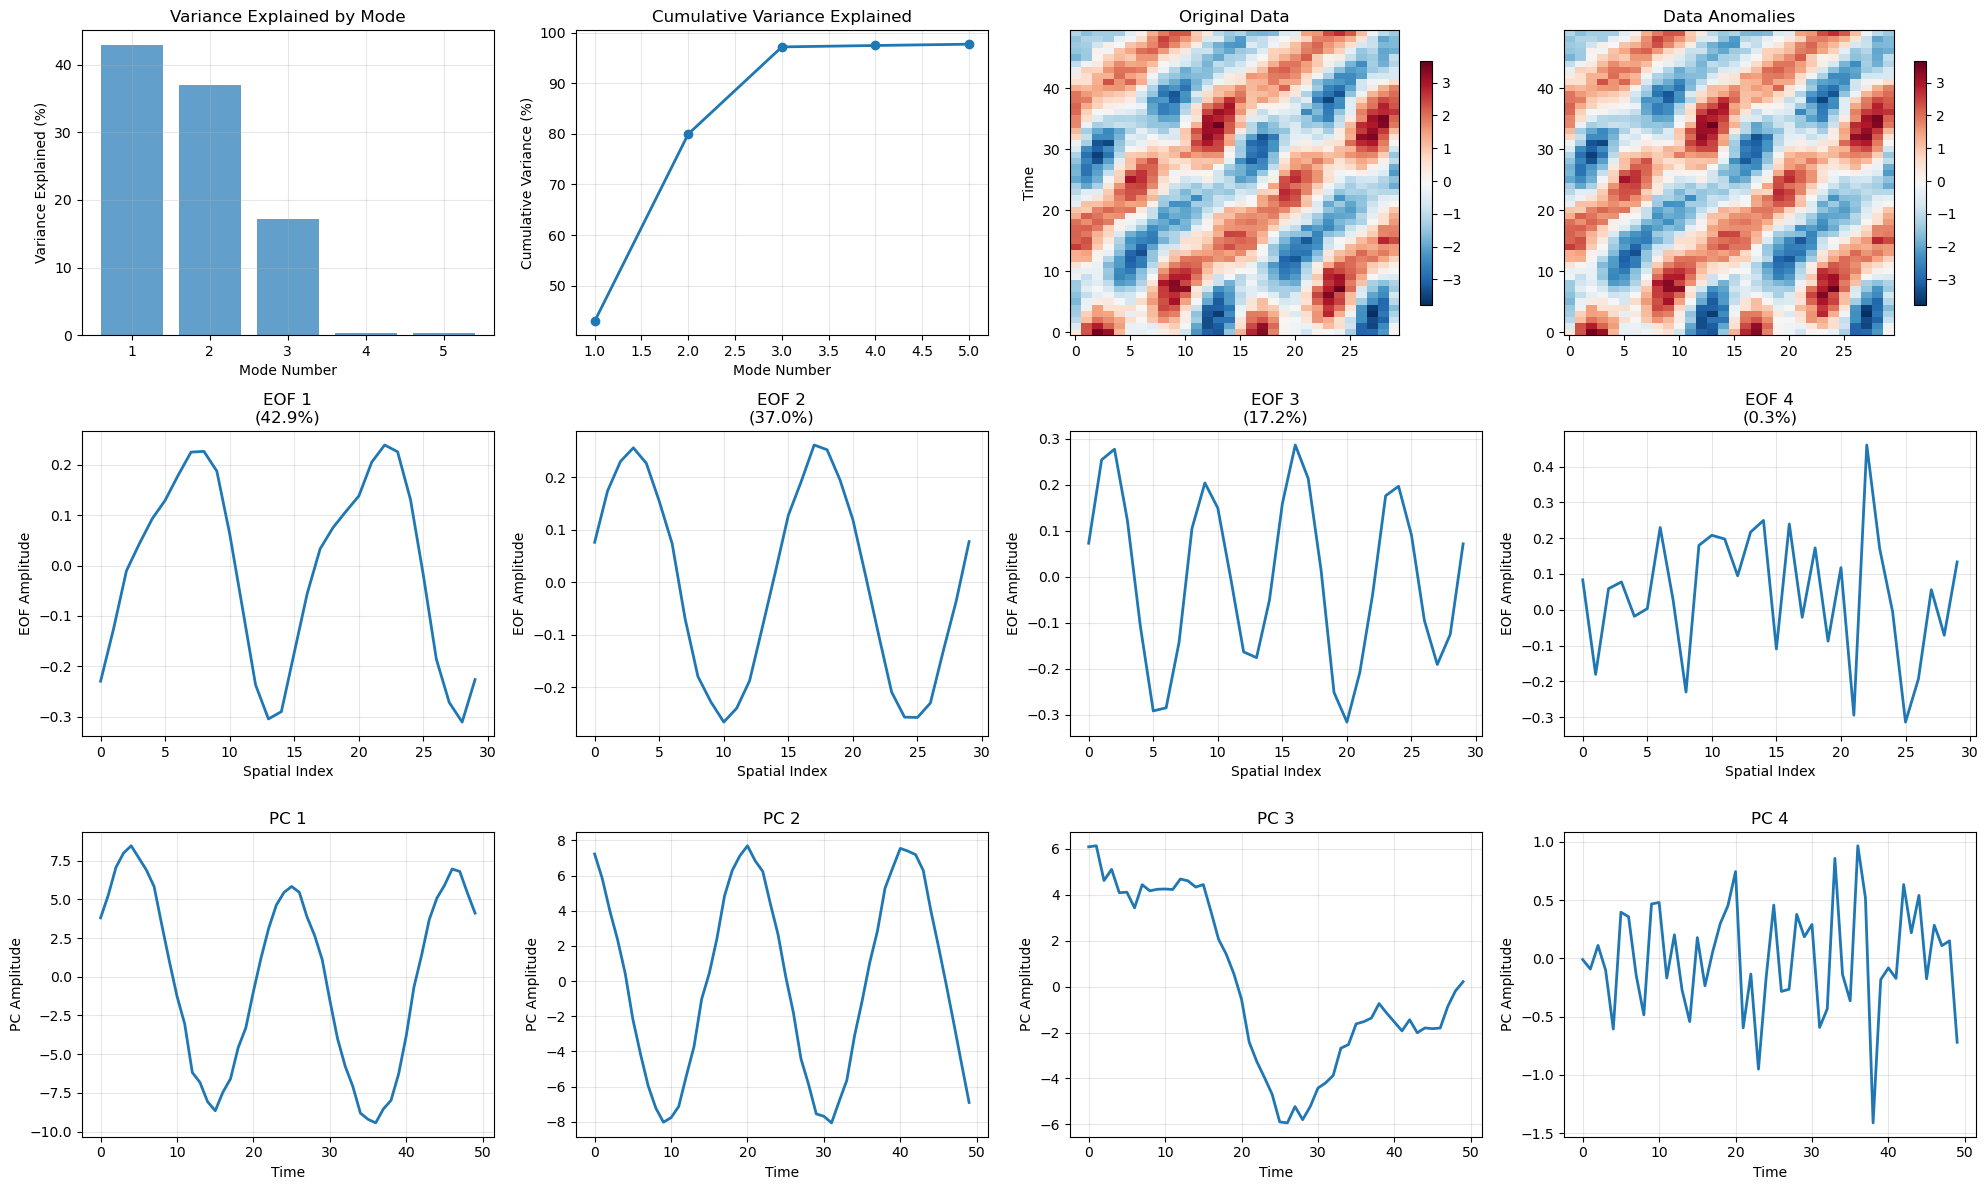

✅ EOF Analysis Complete!


In [17]:
def complete_eof_analysis(data, n_modes=None, plot_results=True):
    """
    Perform complete EOF analysis on spatiotemporal data.
    
    This function encapsulates everything we've learned into a
    professional-quality analysis tool.
    
    Parameters:
    -----------
    data : ndarray, shape (time, space)
        Spatiotemporal data matrix
    n_modes : int, optional
        Number of modes to analyze (default: min(10, data.shape))
    plot_results : bool
        Whether to create visualization plots
        
    Returns:
    --------
    results : dict
        Dictionary containing all EOF analysis results
    """
    print("🚀 Starting Complete EOF Analysis")
    print("=" * 40)
    
    # Data preprocessing
    print("1. Data Preprocessing...")
    original_shape = data.shape
    n_times, n_space = original_shape
    
    # Remove temporal mean to create anomalies
    temporal_mean = np.mean(data, axis=0, keepdims=True)
    data_anomalies = data - temporal_mean
    
    print(f"   Data shape: {original_shape}")
    print(f"   Temporal mean removed at each location")
    
    # SVD decomposition
    print("2. SVD Decomposition...")
    U, s, Vt = np.linalg.svd(data_anomalies, full_matrices=False)
    
    # Calculate EOF quantities
    EOFs = Vt.T  # Spatial patterns
    PCs = U * s  # Principal components (time series)
    eigenvalues = s**2
    explained_variance = eigenvalues / np.sum(eigenvalues)
    
    # Determine number of modes to analyze
    if n_modes is None:
        n_modes = min(10, len(s))
    n_modes = min(n_modes, len(s))
    
    print(f"   Found {len(s)} total modes")
    print(f"   Analyzing first {n_modes} modes")
    
    # Calculate cumulative variance explained
    cumulative_variance = np.cumsum(explained_variance)
    
    print("3. Mode Significance...")
    for i in range(min(5, n_modes)):
        print(f"   Mode {i+1}: {explained_variance[i]*100:.2f}% "
              f"(cumulative: {cumulative_variance[i]*100:.2f}%)")
    
    # Create results dictionary
    results = {
        'EOFs': EOFs[:, :n_modes],
        'PCs': PCs[:, :n_modes],
        'singular_values': s[:n_modes],
        'eigenvalues': eigenvalues[:n_modes],
        'explained_variance': explained_variance[:n_modes],
        'cumulative_variance': cumulative_variance[:n_modes],
        'temporal_mean': temporal_mean,
        'data_anomalies': data_anomalies,
        'original_data': data,
        'n_modes': n_modes
    }
    
    if plot_results:
        _plot_eof_results(results, original_shape)
    
    print("✅ EOF Analysis Complete!")
    return results

def _plot_eof_results(results, original_shape):
    """Helper function to create comprehensive EOF analysis plots."""
    n_times, n_space = original_shape
    n_modes = min(4, results['n_modes'])
    
    # Create spatial and temporal coordinates for plotting
    x_coords = np.arange(n_space)
    t_coords = np.arange(n_times)
    
    # Main results figure
    fig = plt.figure(figsize=(20, 12))
    
    # Variance explained plot
    ax1 = plt.subplot(3, 4, 1)
    modes = np.arange(1, len(results['explained_variance'][:10]) + 1)
    plt.bar(modes, results['explained_variance'][:10] * 100, alpha=0.7)
    plt.title('Variance Explained by Mode')
    plt.xlabel('Mode Number')
    plt.ylabel('Variance Explained (%)')
    plt.grid(True, alpha=0.3)
    
    # Cumulative variance plot
    ax2 = plt.subplot(3, 4, 2)
    plt.plot(modes, results['cumulative_variance'][:10] * 100, 'o-', linewidth=2)
    plt.title('Cumulative Variance Explained')
    plt.xlabel('Mode Number')
    plt.ylabel('Cumulative Variance (%)')
    plt.grid(True, alpha=0.3)
    
    # Original data
    ax3 = plt.subplot(3, 4, 3)
    im1 = plt.imshow(results['original_data'], aspect='auto', origin='lower', cmap='RdBu_r')
    plt.title('Original Data')
    plt.ylabel('Time')
    plt.colorbar(im1, ax=ax3, shrink=0.8)
    
    # Data anomalies
    ax4 = plt.subplot(3, 4, 4)
    im2 = plt.imshow(results['data_anomalies'], aspect='auto', origin='lower', cmap='RdBu_r')
    plt.title('Data Anomalies')
    plt.colorbar(im2, ax=ax4, shrink=0.8)
    
    # EOF spatial patterns
    for i in range(n_modes):
        ax = plt.subplot(3, 4, 5 + i)
        plt.plot(x_coords, results['EOFs'][:, i], linewidth=2)
        plt.title(f'EOF {i+1}\n({results["explained_variance"][i]*100:.1f}%)')
        plt.xlabel('Spatial Index')
        plt.ylabel('EOF Amplitude')
        plt.grid(True, alpha=0.3)
    
    # PC temporal patterns
    for i in range(n_modes):
        ax = plt.subplot(3, 4, 9 + i)
        plt.plot(t_coords, results['PCs'][:, i], linewidth=2)
        plt.title(f'PC {i+1}')
        plt.xlabel('Time')
        plt.ylabel('PC Amplitude')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Test our complete EOF analysis function
print("🧪 Testing Complete EOF Analysis on Our Example Data")
eof_results = complete_eof_analysis(data_matrix, n_modes=5)

### Practical Guidelines for Real Data

Let's discuss some practical considerations for applying EOF analysis to real-world datasets.

In [18]:
def practical_eof_guidelines():
    """
    Provide practical guidance for applying EOF analysis to real data.
    """
    print("📋 Practical Guidelines for EOF Analysis")
    print("=" * 45)
    print()
    
    print("🔍 1. Data Preprocessing:")
    print("   ✓ Always remove temporal mean (climatology)")
    print("   ✓ Consider detrending if long-term trends exist")
    print("   ✓ Check for missing data and handle appropriately")
    print("   ✓ Ensure data is properly gridded/interpolated")
    print()
    
    print("📊 2. Interpreting Results:")
    print("   ✓ Focus on modes that explain significant variance (>5-10%)")
    print("   ✓ Look for physical interpretability in spatial patterns")
    print("   ✓ Examine temporal patterns for known periodicities")
    print("   ✓ Be cautious of modes that might be noise")
    print()
    
    print("⚠️  3. Common Pitfalls:")
    print("   ✗ Don't over-interpret higher-order modes")
    print("   ✗ Avoid assuming EOF patterns represent physical modes")
    print("   ✗ Don't forget that EOFs are mathematical constructs")
    print("   ✗ Be careful with non-stationary data")
    print()
    
    print("✅ 4. Validation Checks:")
    print("   ✓ Verify EOF orthogonality")
    print("   ✓ Check PC temporal correlations")
    print("   ✓ Examine reconstruction errors")
    print("   ✓ Compare with known physical patterns when possible")
    print()
    
    print("🎯 5. Choosing Number of Modes:")
    print("   • Rule of thumb: modes explaining >5% variance")
    print("   • Elbow method: look for break in variance curve")
    print("   • Physical significance: interpretable patterns")
    print("   • Cross-validation: test on independent data")

# Display practical guidelines
practical_eof_guidelines()

📋 Practical Guidelines for EOF Analysis

🔍 1. Data Preprocessing:
   ✓ Always remove temporal mean (climatology)
   ✓ Consider detrending if long-term trends exist
   ✓ Check for missing data and handle appropriately
   ✓ Ensure data is properly gridded/interpolated

📊 2. Interpreting Results:
   ✓ Focus on modes that explain significant variance (>5-10%)
   ✓ Look for physical interpretability in spatial patterns
   ✓ Examine temporal patterns for known periodicities
   ✓ Be cautious of modes that might be noise

⚠️  3. Common Pitfalls:
   ✗ Don't over-interpret higher-order modes
   ✗ Avoid assuming EOF patterns represent physical modes
   ✗ Don't forget that EOFs are mathematical constructs
   ✗ Be careful with non-stationary data

✅ 4. Validation Checks:
   ✓ Verify EOF orthogonality
   ✓ Check PC temporal correlations
   ✓ Examine reconstruction errors
   ✓ Compare with known physical patterns when possible

🎯 5. Choosing Number of Modes:
   • Rule of thumb: modes explaining >5% v

---

## Summary: Your Mathematical Toolkit

Congratulations! You've now mastered the mathematics behind EOF analysis. Let's recap your journey:

### 🎓 What You've Learned:

1. **Intuitive Foundation**: Understanding that pattern-finding means identifying directions of maximum variance in data.

2. **Mathematical Framework**: 
   - Covariance matrices capture relationships between variables
   - Eigenanalysis finds optimal directions automatically
   - SVD extends these concepts to high-dimensional spatiotemporal data

3. **EOF Analysis Pipeline**:
   - Data preprocessing (removing means, creating anomalies)
   - SVD decomposition into spatial and temporal patterns
   - Interpretation of results and validation

4. **Practical Skills**: 
   - Implementing complete EOF analysis
   - Interpreting results correctly
   - Avoiding common pitfalls

### 🧠 Key Mathematical Insights:

- **EOFs are the eigenvectors** of the spatiotemporal covariance matrix
- **Principal components are projections** of the data onto these eigenvectors
- **Singular values tell us** the importance of each pattern
- **Orthogonality ensures** that patterns are mathematically independent

### 🚀 What's Next:

In Notebook 3, you'll apply these tools to real-world datasets and learn advanced interpretation techniques. You'll see how scientists use EOF analysis to understand climate patterns, ocean dynamics, and other complex phenomena.

In [19]:
# Final exercise: Create your own synthetic data and analyze it!
print("🎮 Challenge Exercise:")
print("Create your own spatiotemporal pattern and see if EOF analysis can find it!")

def create_your_pattern():
    """
    Modify this function to create your own synthetic spatiotemporal pattern.
    Then run EOF analysis to see if it can recover your design!
    """
    n_times = 60
    n_locations = 25
    
    # YOUR TURN: Design your own patterns here!
    # Try different combinations of:
    # - Sine waves with different frequencies
    # - Spatial patterns (linear gradients, Gaussians, etc.)
    # - Temporal evolutions (oscillations, trends, etc.)
    
    x = np.linspace(0, 2*np.pi, n_locations)
    t = np.arange(n_times)
    
    # Example: You can modify these patterns
    your_pattern = np.zeros((n_times, n_locations))
    for i, time in enumerate(t):
        # Create your pattern here - this is just an example
        spatial_part = np.sin(x) + 0.5 * np.cos(2*x)
        temporal_part = np.sin(0.2 * time)
        your_pattern[i, :] = spatial_part * temporal_part
    
    # Add some noise
    noise = 0.2 * np.random.randn(n_times, n_locations)
    final_pattern = your_pattern + noise
    
    return final_pattern

# Uncomment these lines to test your pattern:
# your_data = create_your_pattern()
# your_results = complete_eof_analysis(your_data, n_modes=3)
# print("Did EOF analysis recover your intended pattern?")

🎮 Challenge Exercise:
Create your own spatiotemporal pattern and see if EOF analysis can find it!
